### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [1]:
import scipy.io
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from input_utils import *
from metric_utils import *
from train_utils import g_krotov

In [2]:
def ReLU_N(x, k=2):
    mask = x > 0
    x[mask] = x[mask]**k
    x[~mask] = 0
    return x

In [3]:
# def draw_weights(synapses, Kx, Ky):
#     yy=0
#     HM=np.zeros((28*Ky,28*Kx))
#     for y in range(Ky):
#         for x in range(Kx):
#             HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
#             yy += 1
#     plt.clf()
#     nc=np.amax(np.absolute(HM))
#     im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
#     fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
#     plt.axis('off')
#     fig.canvas.draw()   

In [4]:
def draw_weights(synapses, Kx, Ky):
    
    fig, axes = plt.subplots(nrows=Ky, ncols=Kx, figsize=(10,10), dpi=100)
    for y in range(Ky):
        for x in range(Kx):
            axes[y,x].imshow(synapses[y*Ky+x,:].reshape(28,28))
    
    plt.axis('off')
    plt.show()    

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [12]:
device='cpu'
mat = scipy.io.loadmat('mnist_all.mat')

d=784
Nc=10
T=60000

input_data=np.zeros((0,d))
test_data=np.zeros((0,d))

for i in range(Nc):
    input_data=np.concatenate((input_data, mat['train'+str(i)]), axis=0)
    
test_color = []
for i in range(10):
    test_data=np.concatenate((test_data, mat['test'+str(i)]), axis=0)
    test_color.append(np.ones((test_data.shape[0]))*i)
    
test_color = np.concatenate(test_color)

# input_data = StandardScaler().fit_transform(input_data.T).T
# test_data = StandardScaler().fit_transform(test_data.T).T

input_data = 2*(input_data/255.) - 1
test_data = 2*(test_data/255.) - 1

input_data = torch.tensor(input_data, device=device, dtype=torch.float64)
test_data = torch.tensor(test_data, device=device, dtype=torch.float64)

In [13]:
input_data.shape

torch.Size([60000, 784])

In [14]:
input_data.min(), input_data.max()

(tensor(-1., dtype=torch.float64), tensor(1., dtype=torch.float64))

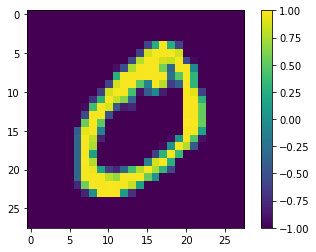

In [15]:
plt.imshow(input_data[0].reshape(28,28))
plt.colorbar()

In [16]:
Kx=10
Ky=10
h=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0

synapses = np.random.normal(mu, sigma, (h, d))
W = torch.tensor(synapses, device=device, dtype=torch.float64)

synapses_r = -np.absolute(np.random.normal(mu, sigma, (h, h)))

W_r = torch.tensor(synapses_r, device=device, dtype=torch.float64)
W_r[np.triu_indices_from(W_r)] = 0
W_r[np.diag_indices_from(W_r)] = 1

In [17]:
epochs=200      # number of epochs
batch_size = 32      # size of the minibatch
eps0=1e-3    # learning rate
prec = 1e-1

In [20]:
%matplotlib inline

for epoch in tqdm(range(epochs)):
    
    eps=eps0 #*(1 - (epoch/epochs))
    
    # shuffle data
    input_data=input_data[np.random.permutation(T),:]
    
    for i in range(T//batch_size):
        
        batch = input_data[i*batch_size:(i+1)*batch_size,:] # take batch [T,d]
        inpt = batch.T # [d,T]
        
        outpt = torch.tanh(W@inpt) 
        output_r = torch.tanh(W_r@outpt)
        
        xx = (output_r*outpt).sum(1)
        dW = (output_r@inpt.T - xx.unsqueeze(1)*W) / batch_size
        
        dWr = -output_r@output_r.T / batch_size 
        
#         dW = torch.true_divide(dW, max(1e-10, dW.abs().max()))
#         dWr = torch.true_divide(dWr, max(1e-10, dWr.abs().max()))
        
        W += eps*dW
        W_r += eps*dWr
        
        W_r[np.triu_indices_from(W_r)] = 0
        W_r[np.diag_indices_from(W_r)] = 1
        W_r[W_r > 0] = 0
        
    clear_output(wait=True)
    draw_weights(to_numpy(W), Kx, Ky)     

  0%|                                                                                                                                        | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
draw_weights(to_numpy(W), Kx, Ky)    

In [ ]:
plt.imshow(W_r == 0)
plt.colorbar()
plt.show()

In [ ]:
# %matplotlib inline

# for epoch in tqdm(range(epochs)):
    
#     eps=eps0 #*(1 - (epoch/epochs))
    
#     # shuffle data
#     input_data=input_data[np.random.permutation(T),:]
    
#     for i in range(T//batch_size):
        
#         batch = input_data[i*batch_size:(i+1)*batch_size,:] # take batch [T,d]
#         inpt = batch.T # [d,T]
        
#         outpt = W@inpt 
# #         outpt = torch.tanh(2*W@inpt)  
#         dW = krotov_rule(inpt, outpt, W) 
#         dW /= batch_size # dW.abs().max()
        
#         W += eps*dW
        
#         W /= torch.norm(W, dim=1, keepdim=True) #- not working for some reason
        
#     clear_output(wait=True)
#     draw_weights(to_numpy(W), Kx, Ky)        


In [ ]:
# plt.figure()
# for i in range(10):
#     plt.hist((W@input_data.T)[i].flatten(), bins=100, alpha=0.1)
# plt.show()

In [ ]:
# x_linspace = np.linspace(-1,1,1000)
# plt.plot(x_linspace, np.tanh(2*x_linspace))
# plt.plot(x_linspace, x_linspace)